In [1]:
import MLMC_RSCAM as multi
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import types

plt.rc('text', usetex=True)
plt.rc('font',**{'serif':['cm']})
plt.style.use('seaborn-paper')
plt.rcParams.update({'font.size':45})

#Define Milstein scheme for GBM SDE
def milstein_GBM(self,X,dt,t_,dW):
    return self.mu*X*dt+self.sig*X*dW+0.5*X*(self.sig**2)*(dW**2-dt)

#Define Milstein scheme for MJD SDE
def milstein_Merton(self,X,dt,t_,dW,dJ=0):
    dx_=(self.r-self.lam*self.J_bar)*X*dt+self.sig*X*dW+0.5*X*(self.sig**2)*(dW**2-dt)
    return dx_+(dx_+X)*dJ

#Define exercise boundary for American option
def exb(self,t):
    return np.maximum(self.K*(1-0.8*np.sqrt(self.T-t)),0)

In [2]:
import matplotlib.pylab as pylab
params = {'figure.titlesize': 'xx-large',
           'legend.fontsize': 'medium',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'lines.linewidth':4}
pylab.rcParams.update(params)

In [ ]:
eps=[0.005,0.01,0.02,0.05,0.1]
M=2
Nsamples=10**5
Lmax=8

opt=multi.Digital_GBM()
fig,ax=plt.subplots(2,2,figsize=(40,40))
markers=['o','s','x','d',(8,2,0)]
multi.Giles_plot(opt,markers=markers,eps=eps,label='Digital Call GBM',fig=fig,
                Nsamples=Nsamples,M=M,Lmax=Lmax,anti=False)

markersize=(fig.get_size_inches()[0])

opt.sde=types.MethodType(milstein_GBM, opt)
cost_mlmc=[]
cost_anti=[]
for e in eps:
    sums,N=opt.mlmc(e,M=M,warm_start=False,anti=False)
    L=len(N)-1
    cost_mlmc+=[np.sum(N*M**(np.arange(L+1)))*e**2]

ax[1,1].loglog(eps,cost_mlmc,'k-',label='Mil. MLMC',marker='o',markersize=markersize,
             markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

sums=np.zeros((4,Lmax+1))
for l in range(Lmax+1):
    sums[:,l]=opt.looper(Nsamples,l,M,anti=False)[:4]
    
means_dp=np.abs(sums[0,:]/Nsamples)
V_dp=sums[1,:]/Nsamples-means_dp**2
means_p=np.abs(sums[2,:]/Nsamples)
V_p=sums[3,:]/Nsamples-means_p**2

s='$\\beta_{Mil}$ = %s' %round(alpha,2)
t = ax[0,0].annotate(s, (Lmax/2, np.log(V_dp[3])/np.log(M)), fontsize=markersize,
        size=2*markersize, bbox=dict(ec='None',facecolor='None',lw=2))
ax[0,0].plot(np.arange(1,Lmax+1),np.log(V_dp[1:])/np.log(M),'k-',label='Mil. $P_{l}-P_{l-1}$',marker='o',
            markersize=markersize,markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

ax[0,0].legend()
ax[1,1].legend()
plt.savefig('DigitalGBM_Mil',format='pdf')


C:\Users\s1505582\Documents\Semester2\RSCAM\Group_Project\Multilevel_MC_SDEs\MLMC_RSCAM.py:1007: RuntimeWarning: divide by zero encountered in log
  a = np.linalg.lstsq(X,np.log(Yl[1:]),rcond=None)[0]


In [ ]:
##Olena or Isabell
eps=[0.005,0.01,0.02,0.05,0.1]
M=2
Nsamples=10**5
Lmax=8

opt=multi.Euro_Merton()
fig,ax=plt.subplots(2,2,figsize=(40,40))
markers=['o','s','x','d',(8,2,0)]
multi.Giles_plot(opt,markers=markers,eps=eps,label='European Call MJD',fig=fig,
                Nsamples=Nsamples,M=M,Lmax=Lmax,anti=False)

markersize=(fig.get_size_inches()[0])

opt.sde=types.MethodType(milstein_Merton, opt)
cost_mlmc=[]
cost_anti=[]
for e in eps:
    sums,N=opt.mlmc(e,M=M,warm_start=False,anti=False)
    L=len(N)-1
    cost_mlmc+=[np.sum(N*M**(np.arange(L+1)))*e**2]

ax[1,1].loglog(eps,cost_mlmc,'k-',label='Mil. MLMC',marker='o',markersize=markersize,
             markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

sums=np.zeros((4,Lmax+1))
for l in range(Lmax+1):
    sums[:,l]=opt.looper(Nsamples,l,M,anti=False)[:4]
    
means_dp=np.abs(sums[0,:]/Nsamples)
V_dp=sums[1,:]/Nsamples-means_dp**2
means_p=np.abs(sums[2,:]/Nsamples)
V_p=sums[3,:]/Nsamples-means_p**2
s='$\\beta_{Mil}$ = %s' %round(alpha,2)
t = ax[0,0].annotate(s, (Lmax/2, np.log(V_dp[3])/np.log(M)), fontsize=markersize,
        size=2*markersize, bbox=dict(ec='None',facecolor='None',lw=2))
ax[0,0].plot(np.arange(1,Lmax+1),np.log(V_dp[1:])/np.log(M),'k-',label='Mil. $P_{l}-P_{l-1}$',marker='o',
            markersize=markersize,markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

ax[0,0].legend()
ax[1,1].legend()
plt.savefig('EuroMJD_Mil',format='pdf')


In [ ]:
##Josh
eps=[0.005,0.01,0.02,0.05,0.1]
M=2
Nsamples=10**5
Lmax=8

opt=multi.Asian_Merton()
fig,ax=plt.subplots(2,2,figsize=(40,40))
markers=['o','s','x','d',(8,2,0)]
multi.Giles_plot(opt,markers=markers,eps=eps,label='Asian Call MJD',fig=fig,
                Nsamples=Nsamples,M=M,Lmax=Lmax,anti=False)

markersize=(fig.get_size_inches()[0])

opt.sde=types.MethodType(milstein_Merton, opt)
cost_mlmc=[]
cost_anti=[]
for e in eps:
    sums,N=opt.mlmc(e,M=M,warm_start=False,anti=False)
    L=len(N)-1
    cost_mlmc+=[np.sum(N*M**(np.arange(L+1)))*e**2]

ax[1,1].loglog(eps,cost_mlmc,'k-',label='Mil. MLMC',marker='o',markersize=markersize,
             markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

sums=np.zeros((4,Lmax+1))
for l in range(Lmax+1):
    sums[:,l]=opt.looper(Nsamples,l,M,anti=False)[:4]
    
means_dp=np.abs(sums[0,:]/Nsamples)
V_dp=sums[1,:]/Nsamples-means_dp**2
means_p=np.abs(sums[2,:]/Nsamples)
V_p=sums[3,:]/Nsamples-means_p**2
s='$\\beta_{Mil}$ = %s' %round(alpha,2)
t = ax[0,0].annotate(s, (Lmax/2, np.log(V_dp[3])/np.log(M)), fontsize=markersize,
        size=2*markersize, bbox=dict(ec='None',facecolor='None',lw=2))
ax[0,0].plot(np.arange(1,Lmax+1),np.log(V_dp[1:])/np.log(M),'k-',label='Mil. $P_{l}-P_{l-1}$',marker='o',
            markersize=markersize,markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

ax[0,0].legend()
ax[1,1].legend()
plt.savefig('AsianMJD_Mil',format='pdf')


In [ ]:
##Chantal
eps=[0.005,0.01,0.02,0.05,0.1]
M=2
Nsamples=10**5
Lmax=8

opt=multi.Lookback_Merton()
fig,ax=plt.subplots(2,2,figsize=(40,40))
markers=['o','s','x','d',(8,2,0)]
multi.Giles_plot(opt,markers=markers,eps=eps,label='Lookback Call MJD',fig=fig,
                Nsamples=Nsamples,M=M,Lmax=Lmax,anti=False)

markersize=(fig.get_size_inches()[0])

opt.sde=types.MethodType(milstein_Merton, opt)
cost_mlmc=[]
cost_anti=[]
for e in eps:
    sums,N=opt.mlmc(e,M=M,warm_start=False,anti=False)
    L=len(N)-1
    cost_mlmc+=[np.sum(N*M**(np.arange(L+1)))*e**2]

ax[1,1].loglog(eps,cost_mlmc,'k-',label='Mil. MLMC',marker='o',markersize=markersize,
             markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

sums=np.zeros((4,Lmax+1))
for l in range(Lmax+1):
    sums[:,l]=opt.looper(Nsamples,l,M,anti=False)[:4]
    
means_dp=np.abs(sums[0,:]/Nsamples)
V_dp=sums[1,:]/Nsamples-means_dp**2
means_p=np.abs(sums[2,:]/Nsamples)
V_p=sums[3,:]/Nsamples-means_p**2

s='$\\beta_{Mil}$ = %s' %round(alpha,2)
t = ax[0,0].annotate(s, (Lmax/2, np.log(V_dp[3])/np.log(M)), fontsize=markersize,
        size=2*markersize, bbox=dict(ec='None',facecolor='None',lw=2))
ax[0,0].plot(np.arange(1,Lmax+1),np.log(V_dp[1:])/np.log(M),'k-',label='Mil. $P_{l}-P_{l-1}$',marker='o',
            markersize=markersize,markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)

ax[0,0].legend()
ax[1,1].legend()
plt.savefig('LookbackMJD_Mil',format='pdf')


## Extra stuff below

In [ ]:
##Testing f(M) and actual cost
cost_mlmc=[]
cost_mc=[]
for m in [2,3,4,5,6,7,8,9,10]:
    Euro=mlmc.Euro_GBM()
    e=0.005
    sums,N=Euro.mlmc(e,M=m)
    L=len(N)-1
    means_p=sums[2,:]/N
    V_p=(sums[3,:]/N)-means_p**2

    cost_mlmc+=[(N[0]+(1+1/m)*np.sum(N[1:]*(m**np.arange(1,L+1))))*e**2]
    cost_mc+=[2*sum(V_p*m**np.arange(L+1))]

M=np.array([2,3,4,5,6,7,8,9,10])
plt.plot(M,cost_mlmc,label='MLMC')
sc=cost_mlmc[3]/((M[3]-1/M[3])/(np.log(M[3]))**2)
plt.plot(M,sc*(M-1/M)/(np.log(M))**2,'r--',label='$f(M)$')
plt.legend()
plt.ylabel('$\epsilon^{2}$cost')
plt.xlabel('$M$');
plt.title(f'Asian Call, GBM, $\epsilon={e}$')
plt.savefig('Comparison_Cost_fofM')

In [ ]:
plt.figure(figsize=(30,16))
eps=np.arange(0.01,0.11,0.01)
option=mlmc.Euro_Merton()
p=[]

for e in eps:
    sums,N=option.mlmc(e,M=2)
    p+=[np.sum(sums[0,:]/N)]
plt.figure(figsize=(30,16))
plt.plot(eps,p,'k--',label='MLMC')
plt.fill_between(eps, p+eps, p-eps, alpha=.5,label='$\pm\epsilon$')
plt.plot(eps,option.BS(100)*np.ones(len(eps)),'k-',label='Black-Scholes')
plt.title(label)
plt.xlabel('$\epsilon$')
plt.ylabel('Call Option Price')
lgd=plt.legend()
text=plt.title(f'European MJD Call Option, $T={option.T}, S(0)={option.X0}, K={option.K}, r={option.r*100}\%, \sigma={option.sig}$',fontsize=36);
plt.savefig('Nice_Images/BSComparison_MJD',bbox_extra_artists=(lgd,text), bbox_inches='tight')

Estimated alpha_0 = 1.5333501792907205
    Saved estimated alpha_0 = 1.5333501792907205
Estimated alpha_0 = 1.9617168754673264
    Saved estimated alpha_0 = 1.9617168754673264
Estimated alpha_0 = 1.0142060932935024
    Saved estimated alpha_0 = 1.0142060932935024


C:\Users\s1505582\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


Estimated alpha_0 = 1.0780193966269147
    Saved estimated alpha_0 = 1.0780193966269147
Estimated alpha_0 = 1.0300634095125518
    Saved estimated alpha_0 = 1.0300634095125518


C:\Users\s1505582\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


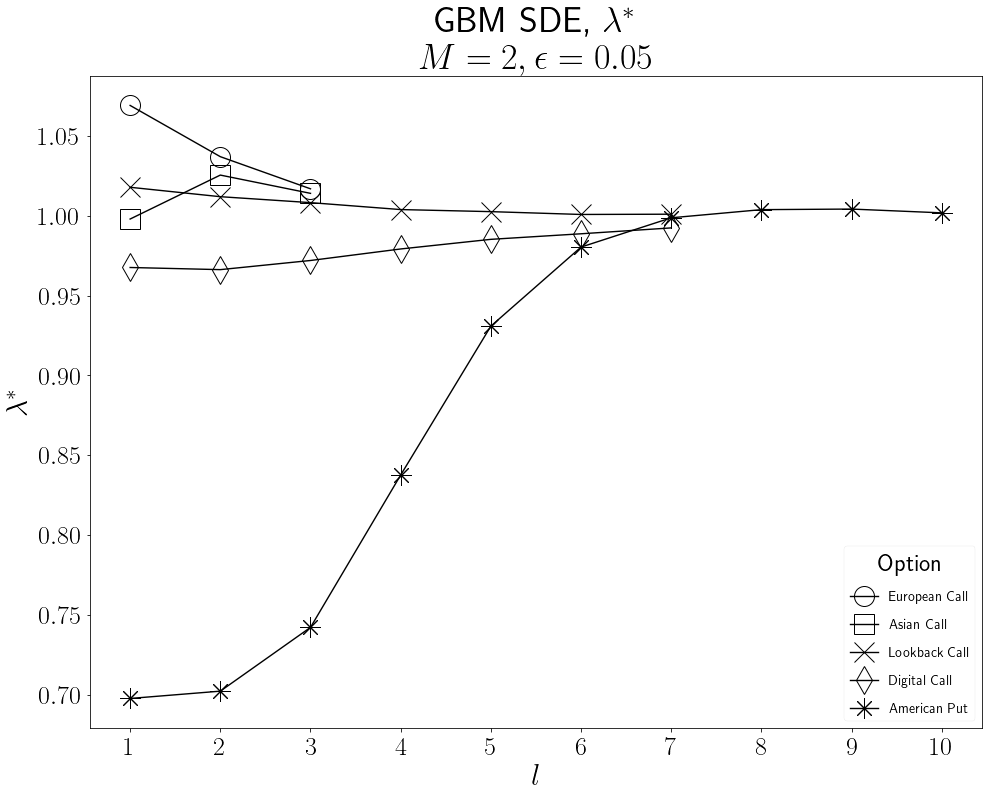

In [3]:
##Testing Control Variate Factor
plt.rcParams['legend.title_fontsize'] = 24
plt.figure(figsize=(16,12))
e=0.05
M=2
plt.title(f'GBM SDE, $\lambda^*$\n$M={M}, \epsilon={e}$');
markers=['o','s','x','d',(8,2,0)]
i=0

def exb(self,t):
    return np.maximum(self.K*(1-0.8*np.sqrt(self.T-t)),0)

for label,func in {'European':mlmc.Euro_GBM,'Asian':mlmc.Asian_GBM,'Lookback':mlmc.Lookback_GBM,
                   'Digital':mlmc.Digital_GBM}.items():
    option=func()
    sums,N=option.mlmc(e,M=M)
    Vg=sums[5,:]/N-(sums[4,:]/N)**2
    lam=((sums[6,:]/N)-(sums[2,:]/N)*(sums[4,:]/N))/Vg
    plt.plot(range(len(N)),lam,'k-',marker=markers[i],label=label+' Call',
               markersize=20,markerfacecolor="None",markeredgecolor='k', markeredgewidth=1)
    i+=1
option=mlmc.Amer_GBM(exerciseBoundary=exb)
sums,N=option.mlmc(e,M=M)
Vg=sums[5,:]/N-(sums[4,:]/N)**2
lam=((sums[6,:]/N)-(sums[2,:]/N)*(sums[4,:]/N))/Vg
plt.plot(range(len(N)),lam,'k-',marker=markers[i],label='American Put',
           markersize=20,markerfacecolor="None",markeredgecolor='k', markeredgewidth=1)
plt.xlabel('$l$')
plt.ylabel('$\lambda^{*}$')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(title='Option',fontsize=14,labelspacing=1)
plt.savefig('Nice_Images/lambdaCallOptions_GBM')

In [ ]:
##Testing linear regression
Euro=Euro_GBM()
lr=LinearRegression()
M=[2,3,4,5,6,7,8,9,10]
alphs=[]
for i in range():
    alphs=[]
    for m in M:
        sums,N=Euro.mlmc(0.01,M=m)
        L=len(N)-1
        Yl=np.abs(sums[0,:])/N
        X=np.arange(1,L+1).reshape(-1,1)
        l = lr.fit(X = X, y = np.log(Yl[1:]))
        alpha = max(0.5,-l.coef_[0]/np.log(m))
        alphs+=[alpha]
    plt.plot(M,alphs,label=f'{i}')
plt.legend()

In [ ]:
import multiprocessing  
 
def func(n):
    for i in range(100):
        for j in range(100):
            s=j*i
    print(n)

if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=4)
    pool.map(func, range(10))
    pool.close()
    pool.join()   
    print('done')

Estimated alpha = 0.6603445477913306
    Saved estimated alpha_0 = 0.6603445477913306


KeyboardInterrupt: 

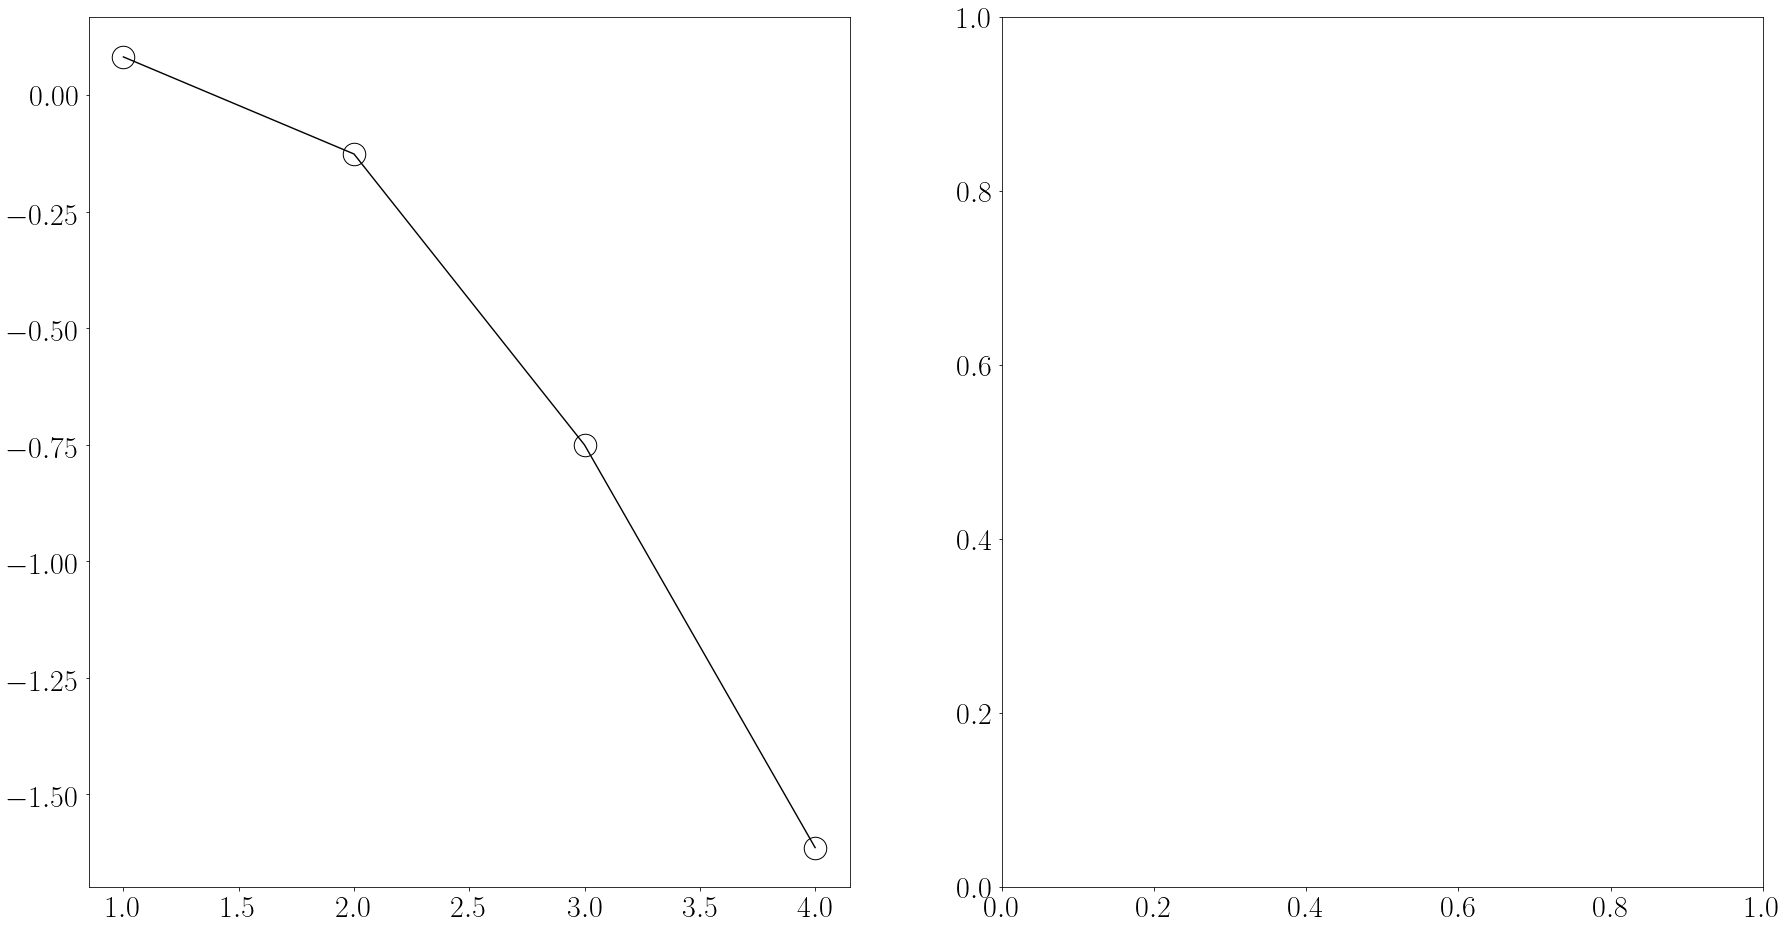

In [7]:
##Jump costs
cost_mc=[]
cost_mlmc=[]
cost_mil=[]
lams=[1,2,3,4,5]
e=0.05
M=2
i=0
fig,ax=plt.subplots(1,2,figsize=(30,16))
axis_list=fig.axes
markers=['o','s','x','d',(8,2,0)]
markersize=3*(fig.get_size_inches()[0])/4

for lam in lams:
    opt=mlmc.Euro_Merton(lam=lam)
    sums,N=opt.mlmc(eps=e,M=M)
    means_p=sums[2,:]/N
    V_p=(sums[3,:]/N)-means_p**2
    means_dp=np.abs(sums[0,:]/N)
    V_dp=sums[1,:]/N-means_dp**2
    L=len(N)-1
    cost_mlmc+=[(np.sum(N)*opt.lam+np.sum(N*(M**np.arange(0,L+1))))*e**2]
    cost_mc+=[2*np.sum(V_p*M**np.arange(L+1))]
    ax[0].plot(np.arange(1,L+1),np.log(V_dp[1:])/np.log(M),'k-',label=f'$\lambda$ = {lam}',marker=markers[i],
            markersize=markersize,markerfacecolor="None",markeredgecolor='k',markeredgewidth=1)
    i+=1
    
def milstein_Merton(self,X,dt,t_,dW,dJ=0):
    dx_=(self.r-self.lam*self.J_bar)*X*dt+self.sig*X*dW+0.5*X*(self.sig**2)*(dW**2-dt)
    return dx_+(dx_+X)*dJ
i=0

for lam in lams:
    opt=mlmc.Euro_Merton(lam=lam)
    opt.sde=types.MethodType(milstein_Merton, opt)
    sums,N=opt.mlmc(eps=e,M=M)
    L=len(N)-1
    cost_mil+=[(np.sum(N)*opt.lam+np.sum(N*(M**np.arange(0,L+1))))*e**2]
    i+=1
    
axis_list[0].legend()
axis_list[0].set_xlabel('$l$')
axis_list[0].set_ylabel('log$_2$(var($Y_l$))')
xa=axis_list[0].xaxis
xa.set_major_locator(ticker.MaxNLocator(integer=True))

axis_list[1].semilogy(lams,cost_mc,'k:',marker=(8,2,0),markersize=markersize,
                 markerfacecolor="None",markeredgecolor='k', markeredgewidth=1,label='Std. MC')
axis_list[1].semilogy(lams,cost_mlmc,'k-',marker=(8,2,0),markersize=markersize,
                 markerfacecolor="None",markeredgecolor='k', markeredgewidth=1,label='MLMC with EM')
axis_list[1].semilogy(lams,cost_mil,'k-',marker='o',markersize=markersize,
                 markerfacecolor="None",markeredgecolor='k', markeredgewidth=1,label='MLMC with Mil.')
xa=axis_list[1].xaxis
xa.set_major_locator(ticker.MaxNLocator(integer=True))
axis_list[1].set_xlabel('$\lambda$')
axis_list[1].set_ylabel('$\epsilon^{2}$cost')
axis_list[1].legend(frameon=True,framealpha=1)
text=fig.suptitle(f'European MJD Call option\n $S(0)={opt.X0}, M=2, \epsilon={e}$')
fig.tight_layout(rect=[0, 0.03, 1, 0.94],h_pad=2,w_pad=4,pad=4)

fig.savefig('Nice_Images/Cost_vs_jumps',bbox_extra_artists=[text],format='pdf')

Estimated alpha = 1.3503781407780848
Estimated alpha = 1.3507662871790227
Estimated alpha = 1.4004464422569238
Estimated alpha = 1.5928442037077835
Estimated alpha = 2.1999664904746328
Estimated alpha = 0.9566759756703026
Estimated alpha = 0.9543013560208764
Estimated alpha = 0.936831811434751
Estimated alpha = 0.923017417490573
Estimated alpha = 1.053411661034791


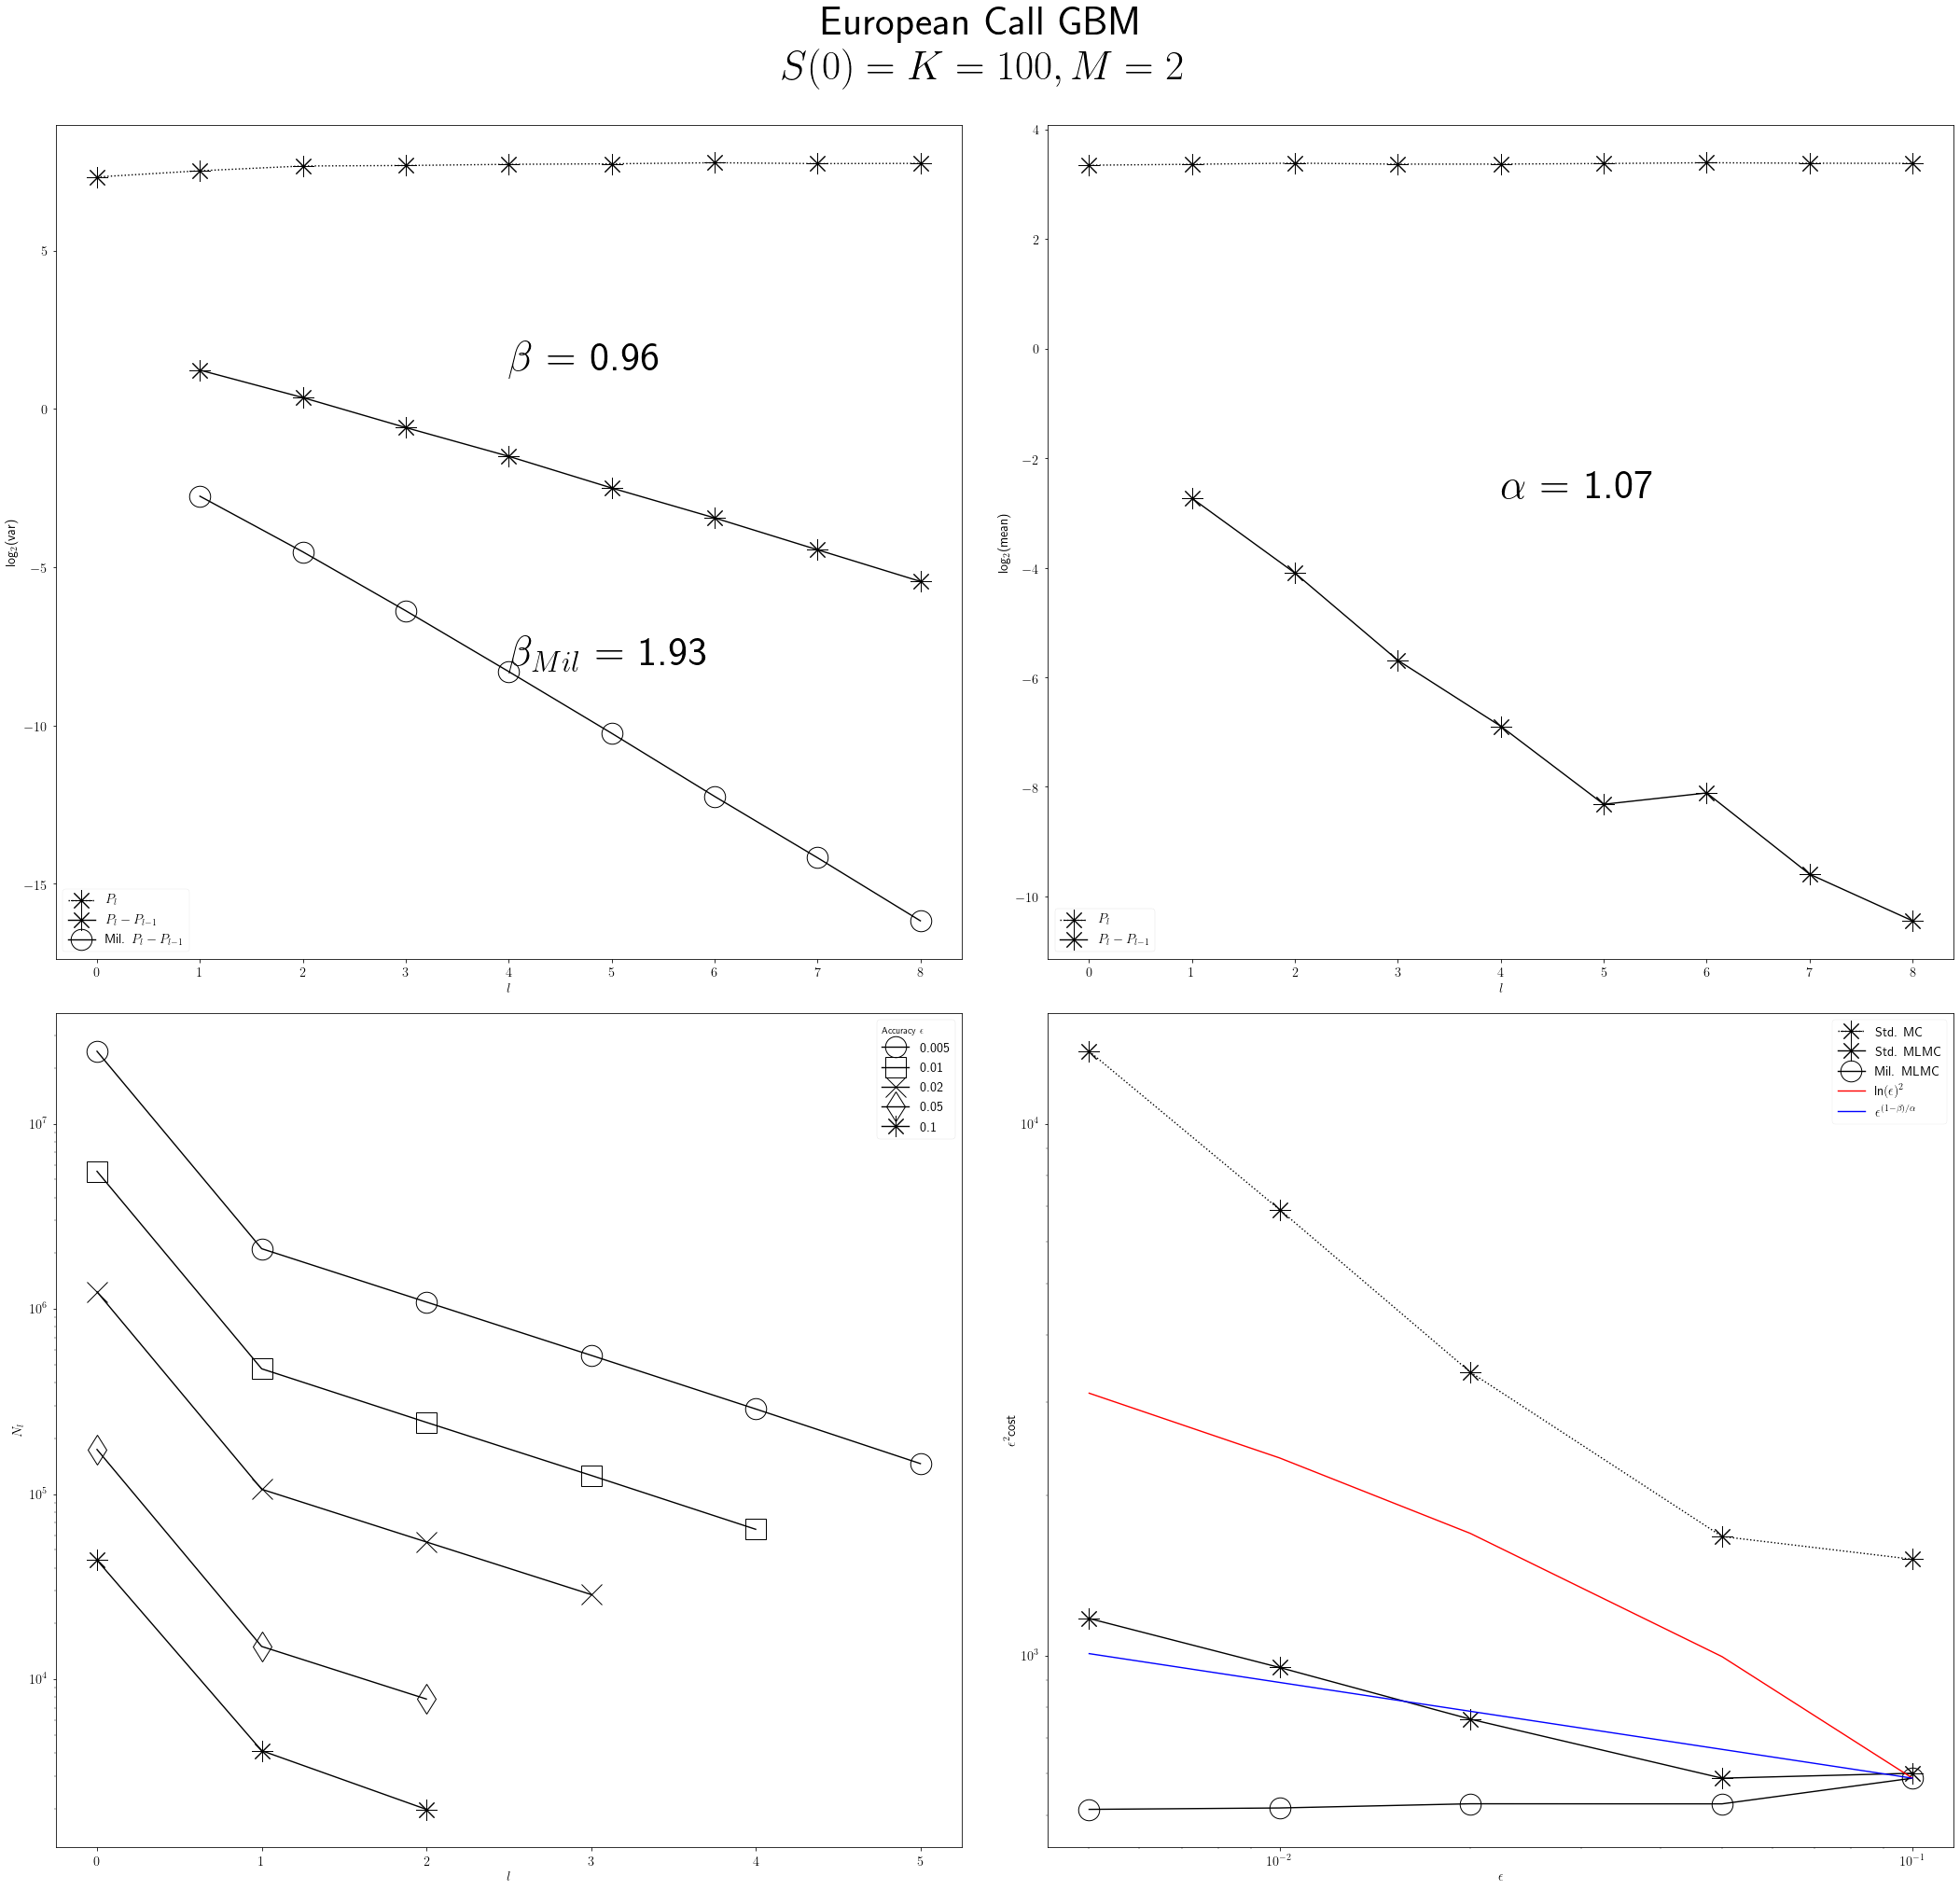